# 1. Setup Mario

In [46]:
!pip install gym_super_mario_bros==7.1.6 nes_py==8.2.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached nes_py-8.2.0-cp311-cp311-win_amd64.whl



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True,render_mode="human" )
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [3]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done, info, _ = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


KeyboardInterrupt: 

# 2. Preprocess Environment

In [ ]:
# Install pytorch
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [9]:
# Install stable baselines for RL stuff
!pip install stable-baselines3[extra]==1.8.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached stable_baselines3-1.8.0-py3-none-any.whl (174 kB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
INFO: pip is looking at multiple versions of stable-baselines3[extra] to determine which version is compatible with other requirements. This could take a while.


ERROR: Could not find a version that satisfies the requirement ale-py==0.7.4; extra == "extra" (from stable-baselines3[extra]) (from versions: 0.8.0, 0.8.1)
ERROR: No matching distribution found for ale-py==0.7.4; extra == "extra"

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [5]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True,render_mode="human" )
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [10]:
state = env.reset()

In [11]:
state, reward, done, info = env.step([5])

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


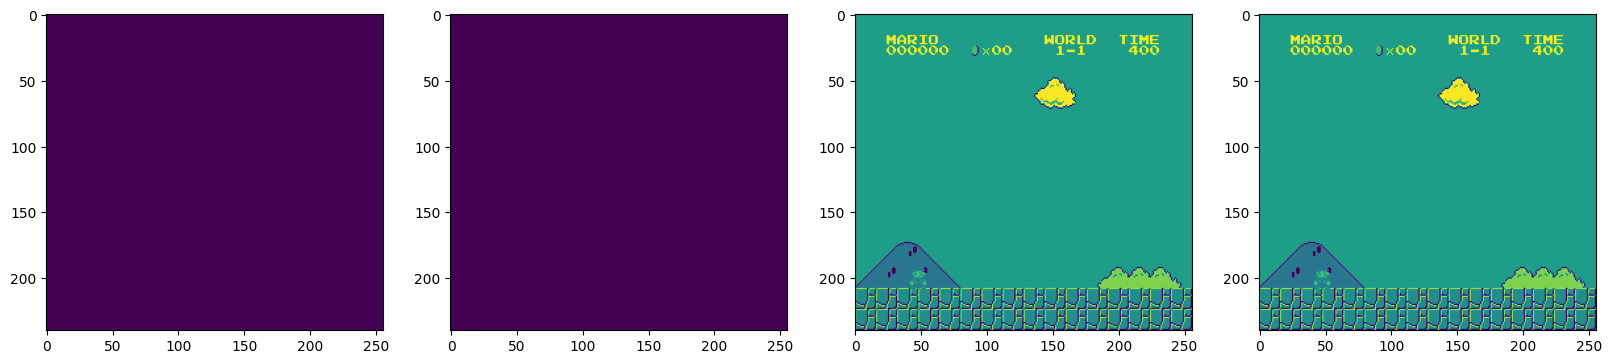

In [12]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [13]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [16]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [17]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [18]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_1
----------------------------
| time/              |     |
|    fps             | 31  |
|    iterations      | 1   |
|    time_elapsed    | 16  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 34            |
|    iterations           | 2             |
|    time_elapsed         | 29            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 5.0555216e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00347       |
|    learning_rate        | 1e-06         |
|    loss                 | 183           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000722     |
|    value_loss           | 462           |
-------------------------

KeyboardInterrupt: 

In [19]:
model.save('thisisatestmodel')

# 4. Test it Out

In [20]:
# Load model
model = PPO.load('./train/best_model_60000')

In [21]:
state = env.reset()

In [23]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

: 